In [1]:
import json
import IPython.display
from IPython.display import display
import io
import os
from PIL import Image
import numpy as np

In [5]:
visual_news_data = json.load(open("visual_news/origin/data.json"))
visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}
clip_data = json.load(open("news_clippings/data/merged_balanced/val.json"))
clip_annotations = clip_data["annotations"]

#queries dataset (validation, change this to test to inspect test results)
queries_val =  json.load(open("dataset_items_val.json"))
queries_val_idx_to_keys = list(queries_val.keys())


In [7]:
##
filter_captions=True 
filter_images_falsified = False 
filter_images_pristine = True  

In [8]:
def load_entities(inv_dict):
    entities = []
    if 'entities' in inv_dict.keys():
        entities = inv_dict['entities']
    if 'best_guess_lbl' in inv_dict.keys():
        entities = entities + inv_dict['best_guess_lbl']
    return entities 

In [9]:
import re 
import string
def preprocess_captions(input_text):
    input_text = re.sub("Photograph:.*","",input_text)
    input_text = input_text.replace("'s", " s")
    input_text = input_text.translate(str.maketrans('', '', string.punctuation))
    input_text = input_text.strip()
    return input_text

415
415
{'id': 385796, 'image_id': 209295, 'similarity_score': 0.7678717374801636, 'source_dataset': 2, 'falsified': True}
Caption:  The Blue House the executive office and residence of Korea s president
Caption source:  usa_today
Original caption of the image:  Police tape surrounds the Canadian War Memorial in Ottawa after a soldier standing guard was shot
Image Path:  ./usa_today/images/0577/507.jpg
Image source:  usa_today
Image Id:  209295
Cap Id:  385796
Is Falsified:  True


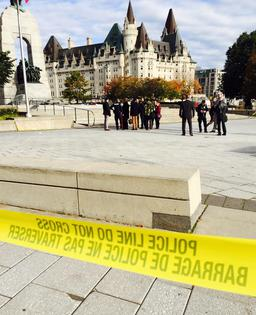

In [15]:
#You can check the query captions and images here.
idx_to_inspect = 415
print(idx_to_inspect)
key_in_clip = queries_val_idx_to_keys[idx_to_inspect]
print(key_in_clip)

ann = clip_annotations[int(key_in_clip)]
print(ann)
caption = visual_news_data_mapping[ann["id"]]["caption"]
caption_image = visual_news_data_mapping[ann["image_id"]]["caption"]

caption_source = visual_news_data_mapping[ann["id"]]["source"]
qimage_path = visual_news_data_mapping[ann["image_id"]]["image_path"]
image_source = visual_news_data_mapping[ann["image_id"]]["source"]

print("Caption: ", caption)
print("Caption source: ", caption_source)
print("Original caption of the image: ", caption_image)
print("Image Path: ", qimage_path)
print("Image source: ", image_source)
print("Image Id: ", ann["image_id"])
print("Cap Id: ", ann["id"])
print("Is Falsified: ", ann["falsified"])
display(IPython.display.Image(filename='visual_news/origin/'+qimage_path.split('./')[1]))



In [1918]:
##read results of that index - find out which batch was it
folder = 'attn_weights'
split = 'val' #change this according to which split to check 
batch_size = 32 #change this according to the batch size of the evaluation
base_inv_dir = 'queries_dataset/inverse_search/val' #change this according to your path and which split you are using 
base_direct_dir = 'queries_dataset/direct_search/val'#change this according to your path and which split you are using 

which_batch = int(idx_to_inspect / batch_size)
index_in_batch = idx_to_inspect - which_batch*batch_size
batch_out = np.load(folder+'/batch_'+str(idx)+'_'+split+'.npz')
pred = batch_out['name1']
P_img = batch_out['name2']
P_cap = batch_out['name3']
P_ent = batch_out['name4']
P_places = batch_out['name5']

pred_instance = pred[index_in_batch]
P_img_instance = P_img[index_in_batch,:]
P_cap_instance = P_cap[index_in_batch,:]
P_ent_instance = P_ent[index_in_batch,:]
P_places_instance = P_places[index_in_batch,:]

In [1921]:
print('true: '+ ('falsified' if ann["falsified"] else 'pristine'))
print('pred: ' + ('falsified' if pred_instance[0]>0.5 else 'pristine'))
print('probability of falsified: '+ str(pred_instance[0]))

true: falsified
pred: falsified
probability of falsified: 0.9999993


## Highest entities 

In [1922]:
###read entities####

inv_dict_file = os.path.join(base_inv_dir,key_in_clip,'inverse_annotation.json') #change the path to the test path if needed
entities = load_entities(json.load(open(inv_dict_file)))
max_n_idx = P_ent_instance.argsort()[-4:][::-1] 
print(entities)
print('****')
print('entity with highest attn weight: '+entities[max_n_idx[0]] + '. attention weight: '+str(P_ent_instance[max_n_idx[0]]))
if len(entities)>1: print('second entity with highest attn weight: '+entities[max_n_idx[1]] + '. attention weight: '+str(P_ent_instance[max_n_idx[1]]))
if len(entities)>2: print('third entity with highest attn weight: '+entities[max_n_idx[2]] + '. attention weight: '+str(P_ent_instance[max_n_idx[2]]))
if len(entities)>3: print('fourth entity with highest attn weight: '+entities[max_n_idx[3]] + '. attention weight: '+str(P_ent_instance[max_n_idx[3]]))


['Parliament Hill', '2014 shootings at Parliament Hill, Ottawa', 'Prime Minister of Canada', 'Parliament of Canada', 'Royal Canadian Mounted Police', 'Ottawa', 'Terrorism', 'Prime minister', 'Michael Zehaf-Bibeau', 'Stephen Harper', 'Kevin Vickers', 'Ontario', 'Canada', 'Ottawa']
****
entity with highest attn weight: 2014 shootings at Parliament Hill, Ottawa. attention weight: 0.11970596
second entity with highest attn weight: Ottawa. attention weight: 0.1047276
third entity with highest attn weight: Michael Zehaf-Bibeau. attention weight: 0.090512834
fourth entity with highest attn weight: Kevin Vickers. attention weight: 0.08863481


## Highest captions

In [1923]:
###read caption###
captions_path = os.path.join(base_inv_dir,key_in_clip,'captions_info')
if os.path.isfile(captions_path):
    captions = json.load(open(captions_path))['captions']
    if (not ann["falsified"]) and filter_captions:
        captions_to_keep_path = os.path.join(base_inv_dir,key_in_clip,'captions_to_keep_idx')
        captions_to_keep_idx = json.load(open(captions_to_keep_path))['index_of_captions_tokeep']
        captions_filtered = [captions[int(i)] for i in captions_to_keep_idx]
    else:
        captions_filtered = captions

    max_n_idx = P_cap_instance.argsort()[-2:][::-1] 

    if len(captions_filtered) >= 2:
        print('caption with highest attn weight: '+captions_filtered[max_n_idx[0]] + '. attention weight: '+str(P_cap_instance[max_n_idx[0]]))
        print('***')
        print('second caption with highest attn weight: '+captions_filtered[max_n_idx[1]] + '. attention weight: '+str(P_cap_instance[max_n_idx[1]]))
    elif len(captions_filtered)==1:
        print('only one caption is available: '+captions_filtered[0] + '. attention weight: '+str(P_cap_instance[0]))
    else: 
        print('no caption found')
else:
    print('no caption found')

    

caption with highest attn weight: Police tape surrounds the Canadian War Memorial in Ottawa after a soldier guarding the monument was shot on Wednesday. (Jim Bronskill / THE CANADIAN PRESS). attention weight: 0.4963671
***
second caption with highest attn weight: Shooting Near Canada's Parliament. attention weight: 0.07858759


In [1924]:
max_n_idx = P_cap_instance.argsort()[-4:][::-1] 
print('third caption with highest attn weight: '+captions_filtered[max_n_idx[3]] + '. attention weight: '+str(P_cap_instance[max_n_idx[3]]))

third caption with highest attn weight: Shooting at War Memorial in Canada Photos - ABC News. attention weight: 0.0515729


## Hightest ResNet (ImageNet) attention 

image with highest attn weight: 5.jpg. attention weight: 1.0


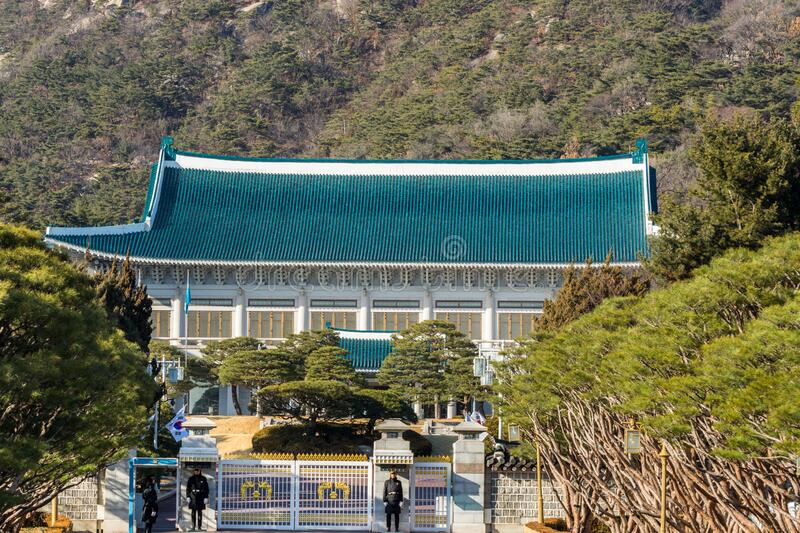

***


IndexError: list index out of range

In [1931]:
if int(key_in_clip)%2 !=0:
    even_key = str(int(key_in_clip) -1)
else:
    even_key = key_in_clip

###read images 
img_info_path = os.path.join(base_direct_dir,even_key,'metadata_of_features')
img_info = json.load(open(img_info_path))
imgs_to_keep_path =  os.path.join(base_direct_dir,even_key,'imgs_to_keep_idx')
imgs_to_keep_idx = json.load(open(imgs_to_keep_path))['index_of_images_tokeep']
imgs_to_keep_idx = np.asarray([int(i) for i in imgs_to_keep_idx])  

filtered_img_info = {}
if filter_images_falsified and ann["falsified"]: 
    for key in img_info.keys():
        if int(key) in imgs_to_keep_idx: filtered_img_info[key] = img_info[key]
elif filter_images_pristine and not ann["falsified"]: 
    for key in img_info.keys():
        if int(key) in imgs_to_keep_idx: filtered_img_info[key] = img_info[key]
else: 
    filtered_img_info = img_info

max_n_idx = P_img_instance.argsort()[-2:][::-1] 
imgs_res_idx_to_keys = list(filtered_img_info.keys())
if len(filtered_img_info) >= 2:
    img_key = imgs_res_idx_to_keys[max_n_idx[0]]
    print('image with highest attn weight: '+filtered_img_info[img_key]['name'] + '. attention weight: '+str(P_img_instance[max_n_idx[0]]))
    image_path = os.path.join(base_direct_dir,even_key,filtered_img_info[img_key]['name'])
    display(IPython.display.Image(filename=image_path))
    print('***')
    img_key = imgs_res_idx_to_keys[max_n_idx[1]]
    print('second image with highest attn weight: '+filtered_img_info[img_key]['name']+ '. attention weight: '+str(P_img_instance[max_n_idx[1]]))
    image_path = os.path.join(base_direct_dir,even_key,filtered_img_info[img_key]['name'])
    display(IPython.display.Image(filename=image_path))
elif len(filtered_img_info)==1:
    img_key = imgs_res_idx_to_keys[max_n_idx[0]]
    print('only one image is available: '+filtered_img_info[img_key]['name'] + '. attention weight: '+str(P_img_instance[0]))
    image_path = os.path.join(base_direct_dir,even_key,filtered_img_info[img_key]['name'])
    display(IPython.display.Image(filename=image_path))
else: 
    print('no image found')



## Hightest places attention 

image with highest attn weight: 0.jpg. attention weight: 0.27790514


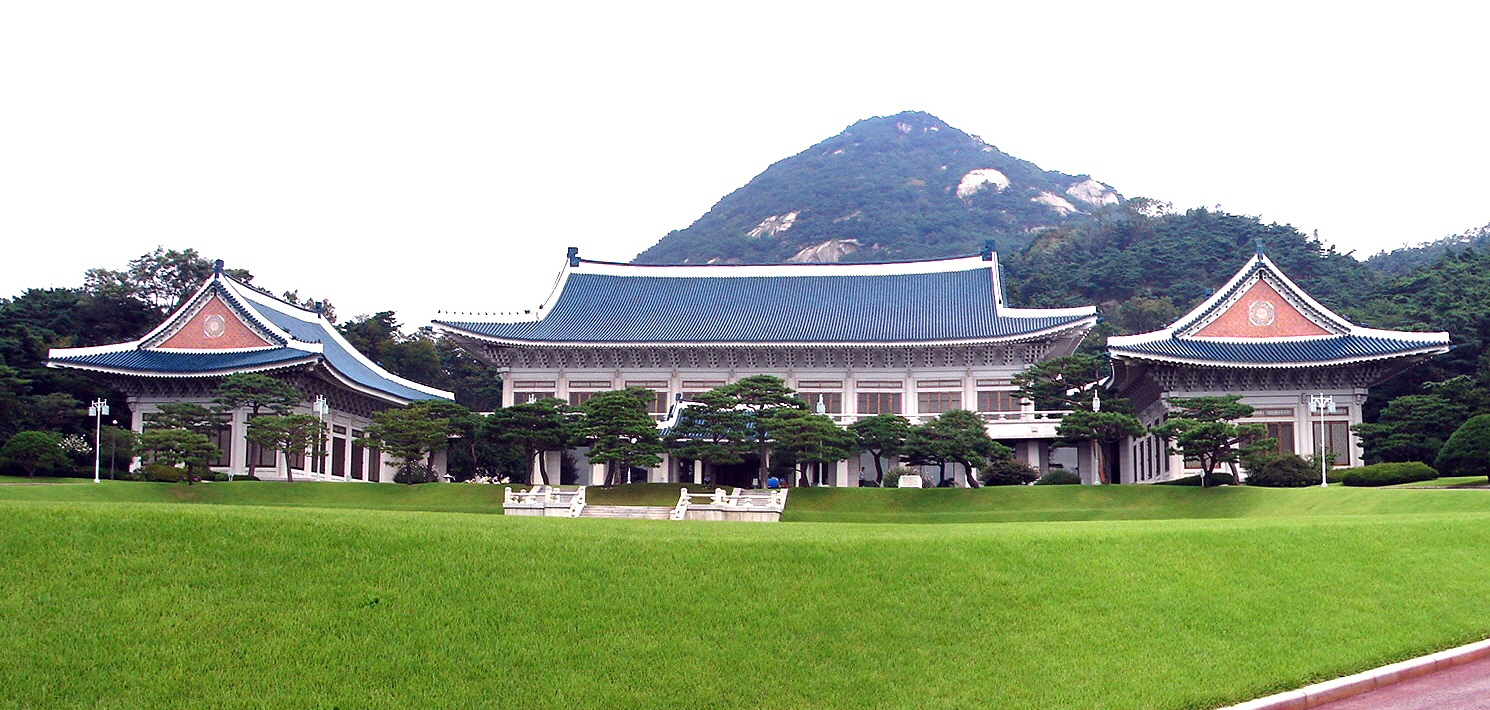

***
second image with highest attn weight: 7.jpg. attention weight: 0.25147244


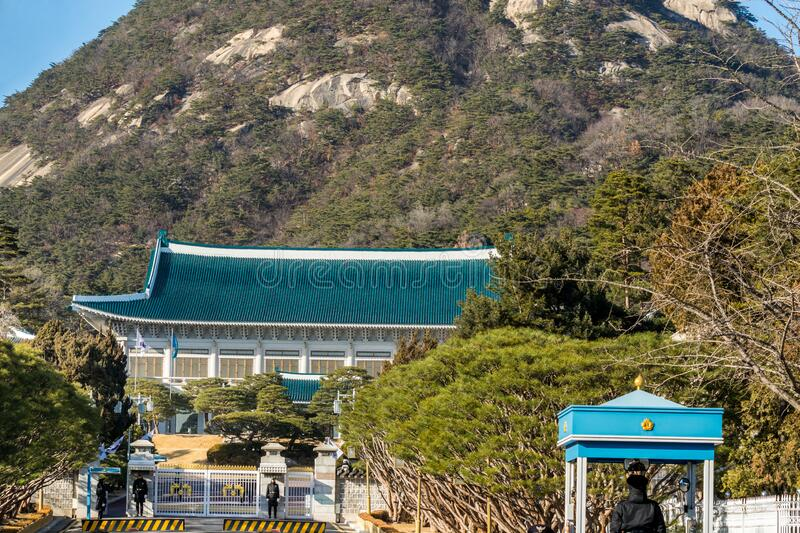

In [1934]:
if int(key_in_clip)%2 !=0:
    even_key = str(int(key_in_clip) -1)
else:
    even_key = key_in_clip

###read images 
img_info_path = os.path.join(base_direct_dir,even_key,'metadata_of_features')
img_info = json.load(open(img_info_path))
imgs_to_keep_path =  os.path.join(base_direct_dir,even_key,'imgs_to_keep_idx')
imgs_to_keep_idx = json.load(open(imgs_to_keep_path))['index_of_images_tokeep']
imgs_to_keep_idx = np.asarray([int(i) for i in imgs_to_keep_idx])  

filtered_img_info = {}
if filter_images_falsified and ann["falsified"]: 
    for key in img_info.keys():
        if int(key) in imgs_to_keep_idx: filtered_img_info[key] = img_info[key]
elif filter_images_pristine and not ann["falsified"]: 
    for key in img_info.keys():
        if int(key) in imgs_to_keep_idx: filtered_img_info[key] = img_info[key]
else: 
    filtered_img_info = img_info

max_n_idx = P_places_instance.argsort()[-2:][::-1] 
imgs_res_idx_to_keys = list(filtered_img_info.keys())
if len(filtered_img_info) >= 2:
    img_key = imgs_res_idx_to_keys[max_n_idx[0]]
    print('image with highest attn weight: '+filtered_img_info[img_key]['name'] + '. attention weight: '+str(P_places_instance[max_n_idx[0]]))
    image_path = os.path.join(base_direct_dir,even_key,filtered_img_info[img_key]['name'])
    display(IPython.display.Image(filename=image_path))
    print('***')
    img_key = imgs_res_idx_to_keys[max_n_idx[1]]
    print('second image with highest attn weight: '+filtered_img_info[img_key]['name']+ '. attention weight: '+str(P_places_instance[max_n_idx[1]]))
    image_path = os.path.join(base_direct_dir,even_key,filtered_img_info[img_key]['name'])
    display(IPython.display.Image(filename=image_path))
elif len(filtered_img_info)==1:
    img_key = imgs_res_idx_to_keys[max_n_idx[0]]
    print('only one image is available: '+filtered_img_info[img_key]['name'] + '. attention weight: '+str(P_places_instance[0]))
    image_path = os.path.join(base_direct_dir,even_key,filtered_img_info[img_key]['name'])
    display(IPython.display.Image(filename=image_path))
else: 
    print('no image found')

